In [1]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from Lib.L2R.code.model_agnostic import PlugInRule, PlugInRuleAUC, SCRoss
import matplotlib.pyplot as plt
from MyLoreSA.metrics import nonrejected_accuracy, classification_quality, rejection_quality, rejection_classification_report

In [2]:
# // Load data
perc_hold = 0.125
perc_test = 0.2
# the name of columns of the dataset
columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "work_hours",
    "native_country",
    "inc",
]

# here we shuffle train and test set
df_train = pd.read_csv("Lib/L2R/data/raw/adult.data", names=columns)
df_test = pd.read_csv("Lib/L2R/data/raw/adult.test", names=columns, skiprows=1)
df_train["TARGET"] = np.where(df_train["inc"] == " >50K", 1, 0)
df_test["TARGET"] = np.where(df_test["inc"] == " >50K.", 1, 0)
df_train.drop(columns=["inc", "education"], inplace=True) # here we drop additional columns that we do not need
df_test.drop(columns=["inc", "education"], inplace=True) # here we drop additional columns that we do not need
df = pd.concat([df_train, df_test], axis=0) #concat the two dataset
df.reset_index(inplace=True) #reset index
#here we define the final columns of the dataset
atts = [
    "age",
    "workclass",
    "fnlwgt",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "work_hours",
    "native_country",
]
# here we distinguish between categorical and numerical attributes
cat_atts = []
cont_atts = []
for col in atts:
    if df_train[col].dtype == object:
        #         df_train[col] = df_train[col].astype('category').cat.codes
        cat_atts.append(col)
    else:
        #         df_train[col] = df_train[col].astype(float)
        cont_atts.append(col)
# here we one hot encode categorical attributes
df = pd.get_dummies(df, columns=cat_atts)
# here we remove the extra spaces from the column names of the dataset
df.columns = [col.replace(" ", "") for col in df.columns]
# here we remove the "weird" characters from the column names of the dataset
df.columns = [col.replace("?", "UNK") for col in df.columns]
# here we define the final set of features to be used in the classification task
atts = [col for col in df.columns if col not in ["TARGET", "index"]]
# here we create test set using perc_test and calibration set using perc_hold
df_train_, df_test = train_test_split(
    df, random_state=42, test_size=perc_test, stratify=df["TARGET"]
)
df_train, df_cal = train_test_split(
    df_train_, random_state=42, test_size=perc_hold, stratify=df_train_["TARGET"]
)


# The selective classification framework

Selective classification allows classifiers to abstain from predicting, avoiding making mistakes over difficult instances. In this notebook we show how to use the selective classification framework to train selective classifiers and evaluate them. We use the Adult dataset, which is a binary classification task. We use the LightGBM classifier as base model for the selective classifiers. We train the selective classifiers using the training set, calibrate them using the calibration set, and evaluate them using the test set. We use the accuracy as metric for the evaluation of the selective classifiers. We also show how to use the AUC as metric for the evaluation of the selective classifiers.

More formally we have:
- $X$ are the features
- $Y$ are the target variables
- $f: X \rightarrow Y$ is the base classifier
- $g: X \rightarrow \{0,1\}$ is the selection function

The selective classifier is then the pair $(f,g)$, i.e.

\begin{equation}
(f,g)(x) = \begin{cases}
f(x) \quad \text{if } g(x) = 1 \\
\text{abstain} \quad \text{if } g(x) = 0
\end{cases}
\end{equation}

To build a selective classifier, one has to specify a target coverage $c \in [0,1]$, which is the percentage of instances that the selective classifier is allowed to abstain from predicting. The selective classifier is then calibrated to predict on $c$ fraction of the instances. Depending on the methodology, one might need a calibration set to calibrate the selective classifier to achieve the target coverage. Ideally, the more we abstain the more we reduce the number of mistakes, hence performance should improve.

In [3]:
# // Train selective classifiers
# here we define the base model to be used by the selective classifiers
clf_base = XGBClassifier(random_state=42)
# here we define the selective classifiers
# plugin : plug-in rule by Herbei and Wegkamp
# plugin_auc : plug-in rule by Pugnana and Ruggieri, 2023b - a plug-in rule that improves AUC when abstaining
# scr : cross-fitting approach by Pugnana and Ruggieri, 2023a - a method that uses cross-fitting to avoid overfitting and reserve some data for calibration
plg = PlugInRule(clf_base)
plg_auc = PlugInRuleAUC(clf_base)
scr = SCRoss(clf_base)

In [4]:
# here we train the selective classifiers
plg.fit(df_train[atts], df_train["TARGET"])
plg_auc.fit(df_train[atts], df_train["TARGET"])
scr.fit(df_train_[atts], df_train_["TARGET"])

In [5]:
#calibrate selective classifiers for target coverages
rej_rate_list = np.linspace(0,0.99,num=100)
target_coverages = [1-n for n in rej_rate_list]

#target_coverages = [.99, .75, .50] # here we define the target coverages for the selective classifiers
plg.calibrate(df_cal[atts], target_coverages=target_coverages)
plg_auc.calibrate(df_cal[atts], df_cal["TARGET"], target_coverages=target_coverages)
scr.calibrate(target_coverages=target_coverages)

In [6]:
# // Evaluate selective classifiers
# here we create an array containing levels for acceptance depending on how the selective classifiers are calibrated
# since we used 100 target coverages, we have 101 levels of acceptance, i.e., 0, 1, 2, 3, ..., 100
selected_plg = plg.qband(df_test[atts])
selected_plg_auc = plg_auc.qband(df_test[atts])
selected_scr = scr.qband(df_test[atts])

In [30]:
def get_index_rejected(qband_list, i):
    rejected_list = []
    for j in range(len(qband_list)):
        qband = qband_list[j]
        if qband >= i:
            rejected_list.append(j)
    return rejected_list

In [19]:
# create: rejected_list is a 0/1 list with 1 at rejected indices
# qband is a list with levels of acceptance: for j in range(len(target_coverage)), qband>=j is rejected
# qband >= i means setting to 0 (accept) all samples above i
def get_rejected_list(qband, i):
    n = len(qband)
    rejected_list = [1]*n
    for j in range(n):
        if qband[j] >= i:
            rejected_list[j] = 0
    return rejected_list

In [32]:
#y_pred_plg = plg.predict(df_test[atts])
rejected_by_coverage_plg = dict()
rejected_by_coverage_plgauc = dict()
rejected_by_coverage_scr = dict()
n = len(df_test['TARGET'])

for i in range(100):
    qband = i
    cov = 1 - target_coverages[i] # save as rejection rate, not coverage
    #rejected list is a 0/1 list with 1 at rejected indices
    rejected_list_plg = get_rejected_list(selected_plg, i)
    rejected_list_plgauc = get_rejected_list(selected_plg_auc, i)
    rejected_list_scr = get_rejected_list(selected_scr, i)
    
    correct_nonrejected_plg, correct_rejected_plg, miscl_nonrejected_plg, miscl_rejected_plg, df_plg = rejection_classification_report(df_test['TARGET'], 
                                                                                                               plg.predict(df_test[atts]), 
                                                                                                               rejected_list_plg)
    
    correct_nonrejected_plgauc, correct_rejected_plgauc, miscl_nonrejected_plgauc, miscl_rejected_plgauc, df_plgauc = rejection_classification_report(df_test['TARGET'], 
                                                                                                               plg_auc.predict(df_test[atts]), 
                                                                                                               rejected_list_plgauc)
    
    correct_nonrejected_scr, correct_rejected_scr, miscl_nonrejected_scr, miscl_rejected_scr, df_scr = rejection_classification_report(df_test['TARGET'], 
                                                                                                               scr.predict(df_test[atts]), 
                                                                                                               rejected_list_scr)
   
   # n = len(df_test['TARGET'])
    # get performance metrics
    AN_plg = nonrejected_accuracy(correct_nonrejected_plg, miscl_nonrejected_plg)
    AN_plgauc = nonrejected_accuracy(correct_nonrejected_plgauc, miscl_nonrejected_plgauc)
    AN_scr = nonrejected_accuracy(correct_nonrejected_scr, miscl_nonrejected_scr)
   # CQ = classification_quality(correct_nonrejected_plg, miscl_rejected_plg, n)
    #RQ = rejection_quality(correct_rejected_plg, correct_nonrejected_plg, miscl_rejected_plg, miscl_nonrejected_plg)
    
    
    rejected_by_coverage_plg[cov] = AN_plg
    rejected_by_coverage_plgauc[cov] = AN_plgauc
    rejected_by_coverage_scr[cov] = AN_scr




Text(0, 0.5, 'Non-rejected accuracy')

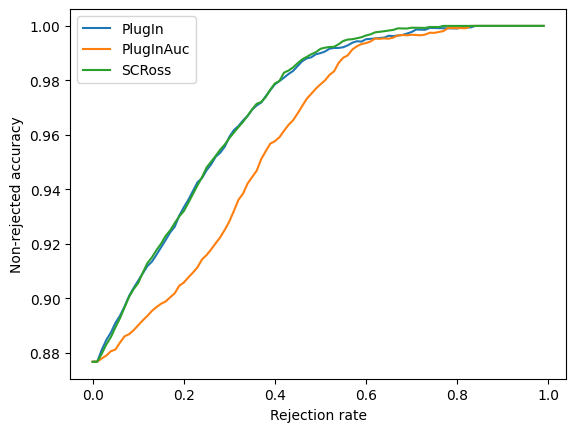

In [33]:
plt.plot(rejected_by_coverage_plg.keys(), rejected_by_coverage_plg.values(), label='PlugIn')
plt.plot(rejected_by_coverage_plgauc.keys(), rejected_by_coverage_plgauc.values(), label = 'PlugInAuc')
plt.plot(rejected_by_coverage_scr.keys(), rejected_by_coverage_scr.values(), label='SCRoss')
plt.legend()
plt.xlabel('Rejection rate')
plt.ylabel('Non-rejected accuracy')

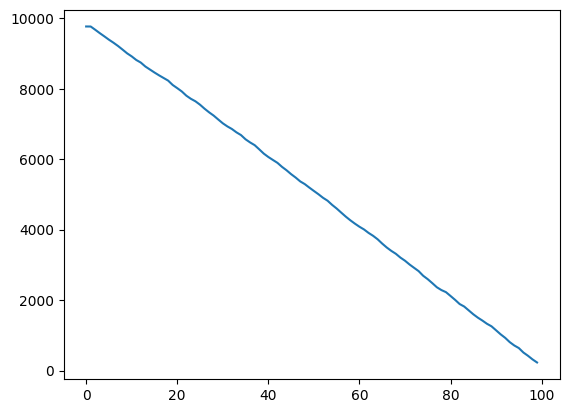

In [35]:

# rejection_list is a list with 0=predict, 1=reject
correct_nonrejected, correct_rejected, miscl_nonrejected, miscl_rejected, df = rejection_classification_report(df_test['TARGET'], 
                                                                                                               plg.predict(df_test[atts]), 
                                                                                                               rejection_list)
n = len(df_test['TARGET'])
# get performance metrics
AN = nonrejected_accuracy(correct_nonrejected, miscl_nonrejected)
CQ = classification_quality(correct_nonrejected, miscl_rejected, n)
RQ = rejection_quality(correct_rejected, correct_nonrejected, miscl_rejected, miscl_nonrejected)

In [33]:
rejected_by_coverage_plg[0.95]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 49,
 50,
 51,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 18

In [7]:
# check that the selective classifiers are able to identify instances where they make less mistakes
print("PLG - full coverage: ", accuracy_score(df_test["TARGET"][selected_plg>=0], plg.predict(df_test[atts][selected_plg>=0])))
print("PLG - predicting on 99% of cases: ", accuracy_score(df_test["TARGET"][selected_plg>=1], plg.predict(df_test[atts][selected_plg>=1])))
print("PLG - predicting on 75% of cases: ", accuracy_score(df_test["TARGET"][selected_plg>=2], plg.predict(df_test[atts][selected_plg>=2])))
print("PLG - predicting on 50% of cases: ", accuracy_score(df_test["TARGET"][selected_plg>=3], plg.predict(df_test[atts][selected_plg>=3])))

PLG - full coverage:  0.8756269833145665
PLG - predicting on 99% of cases:  0.8792604833712043
PLG - predicting on 75% of cases:  0.9482135688478522
PLG - predicting on 50% of cases:  0.9895833333333334


In [8]:
print("PLG AUC - full coverage: ", accuracy_score(df_test["TARGET"][selected_plg_auc>=0], plg_auc.predict(df_test[atts][selected_plg_auc>=0])))
print("PLG AUC - predicting on 99% of cases: ", accuracy_score(df_test["TARGET"][selected_plg_auc>=1], plg_auc.predict(df_test[atts][selected_plg_auc>=1])))
print("PLG AUC - predicting on 75% of cases: ", accuracy_score(df_test["TARGET"][selected_plg_auc>=2], plg_auc.predict(df_test[atts][selected_plg_auc>=2])))
print("PLG AUC - predicting on 50% of cases: ", accuracy_score(df_test["TARGET"][selected_plg_auc>=3], plg_auc.predict(df_test[atts][selected_plg_auc>=3])))

PLG AUC - full coverage:  0.8756269833145665
PLG AUC - predicting on 99% of cases:  0.876993166287016
PLG AUC - predicting on 75% of cases:  0.916712479384277
PLG AUC - predicting on 50% of cases:  0.9800558436378142


In [9]:
print("SCR - full coverage: ", accuracy_score(df_test["TARGET"][selected_scr>=0], scr.predict(df_test[atts][selected_scr>=0])))
print("SCR - predicting on 99% of cases: ", accuracy_score(df_test["TARGET"][selected_scr>=1], scr.predict(df_test[atts][selected_scr>=1])))
print("SCR - predicting on 75% of cases: ", accuracy_score(df_test["TARGET"][selected_scr>=2], scr.predict(df_test[atts][selected_scr>=2])))
print("SCR - predicting on 50% of cases: ", accuracy_score(df_test["TARGET"][selected_scr>=3], scr.predict(df_test[atts][selected_scr>=3])))

SCR - full coverage:  0.8759340771829256
SCR - predicting on 99% of cases:  0.8794721105268585
SCR - predicting on 75% of cases:  0.9488873904248145
SCR - predicting on 50% of cases:  0.9901368760064412


In [ ]:
# check what happens when changing metric to AUC

In [33]:
print("PLG - full coverage: ", roc_auc_score(df_test["TARGET"][selected_plg>=0], plg.predict_proba(df_test[atts][selected_plg>=0])[:,1]))
print("PLG - predicting on 99% of cases: ", roc_auc_score(df_test["TARGET"][selected_plg>=1], plg.predict_proba(df_test[atts][selected_plg>=1])[:,1]))
print("PLG - predicting on 75% of cases: ", roc_auc_score(df_test["TARGET"][selected_plg>=2], plg.predict_proba(df_test[atts][selected_plg>=2])[:,1]))
print("PLG - predicting on 50% of cases: ", roc_auc_score(df_test["TARGET"][selected_plg>=3], plg.predict_proba(df_test[atts][selected_plg>=3])[:,1]))

PLG - full coverage:  0.9299814639133982
PLG - predicting on 99% of cases:  0.9314342951664598
PLG - predicting on 75% of cases:  0.9598424240705253
PLG - predicting on 50% of cases:  0.9884235349349638


In [32]:
print("PLG AUC - full coverage: ", roc_auc_score(df_test["TARGET"][selected_plg_auc>=0], plg_auc.predict_proba(df_test[atts][selected_plg_auc>=0])[:,1]))
print("PLG AUC - predicting on 99% of cases: ", roc_auc_score(df_test["TARGET"][selected_plg_auc>=1], plg_auc.predict_proba(df_test[atts][selected_plg_auc>=1])[:,1]))
print("PLG AUC - predicting on 75% of cases: ", roc_auc_score(df_test["TARGET"][selected_plg_auc>=2], plg_auc.predict_proba(df_test[atts][selected_plg_auc>=2])[:,1]))
print("PLG AUC - predicting on 50% of cases: ", roc_auc_score(df_test["TARGET"][selected_plg_auc>=3], plg_auc.predict_proba(df_test[atts][selected_plg_auc>=3])[:,1]))

PLG AUC - full coverage:  0.9299814639133982
PLG AUC - predicting on 99% of cases:  0.9319424790167712
PLG AUC - predicting on 75% of cases:  0.9684671594950266
PLG AUC - predicting on 50% of cases:  0.9919272689795878
